# Transfer Learning for CV

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

The problem we’re going to solve today is to `train a model to classify ants and bees`. We have about **120 training images** each for ants and bees. There are 75 validation images for each class. Usually, this is a **very small dataset** to generalize upon, if **trained from scratch**. Since we are using transfer learning, we should be able to generalize reasonably well.

## Load Data

In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x108907d00>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x10479b8e0>}

## Visualize a few images

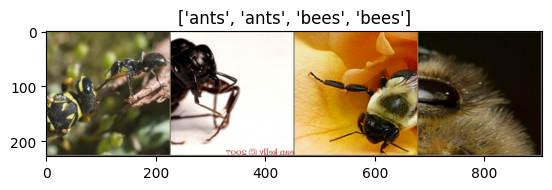

In [3]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training the model

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

## Visualizing the model predictions

In [5]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
from torchinfo import summary
model_ft = models.resnet18(weights='IMAGENET1K_V1')

summary(model_ft, input_size=(4, 3, 224, 224))

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─BasicBlock: 2-1                   --
│    │    └─Conv2d: 3-1                  36,864
│    │    └─BatchNorm2d: 3-2             128
│    │    └─ReLU: 3-3                    --
│    │    └─Conv2d: 3-4                  36,864
│    │    └─BatchNorm2d: 3-5             128
│    └─BasicBlock: 2-2                   --
│    │    └─Conv2d: 3-6                  36,864
│    │    └─BatchNorm2d: 3-7             128
│    │    └─ReLU: 3-8                    --
│    │    └─Conv2d: 3-9                  36,864
│    │    └─BatchNorm2d: 3-10            128
├─Sequential: 1-6                        --
│    └─BasicBlock: 2-3                   --
│    │    └─Conv2d: 3-11                 73,728

## Fine-tuning the ConvNet

In [6]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/martinperez/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:37<00:00, 1.24MB/s]


## Train and evaluate

In [7]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5928 Acc: 0.7090
val Loss: 0.3059 Acc: 0.8824

Epoch 1/24
----------
train Loss: 0.5752 Acc: 0.8033
val Loss: 0.2628 Acc: 0.8954

Epoch 2/24
----------
train Loss: 0.4804 Acc: 0.8279
val Loss: 0.3183 Acc: 0.8693

Epoch 3/24
----------
train Loss: 0.4531 Acc: 0.8115
val Loss: 0.3718 Acc: 0.8627

Epoch 4/24
----------
train Loss: 0.3887 Acc: 0.8402
val Loss: 0.3019 Acc: 0.8758

Epoch 5/24
----------
train Loss: 0.5427 Acc: 0.7828
val Loss: 0.1918 Acc: 0.9216

Epoch 6/24
----------
train Loss: 0.3695 Acc: 0.8484
val Loss: 0.3548 Acc: 0.8627

Epoch 7/24
----------
train Loss: 0.4010 Acc: 0.8074
val Loss: 0.2192 Acc: 0.9085

Epoch 8/24
----------
train Loss: 0.3348 Acc: 0.8320
val Loss: 0.2059 Acc: 0.9085

Epoch 9/24
----------
train Loss: 0.2782 Acc: 0.8934
val Loss: 0.2263 Acc: 0.9020

Epoch 10/24
----------
train Loss: 0.2563 Acc: 0.8811
val Loss: 0.2049 Acc: 0.9020

Epoch 11/24
----------
train Loss: 0.2803 Acc: 0.8648
val Loss: 0.1822 Acc: 0.9085

Ep

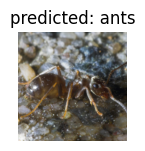

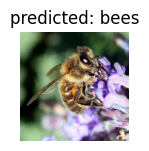

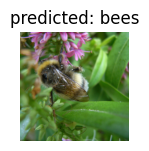

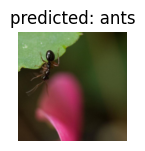

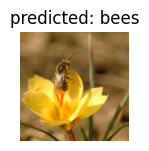

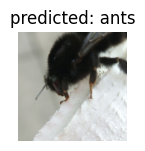

In [8]:
visualize_model(model_ft)

## ConvNet as fixed feature extractor


In [9]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

## Train and evaluate

In [10]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6048 Acc: 0.6803
val Loss: 0.2326 Acc: 0.9346

Epoch 1/24
----------
train Loss: 0.6812 Acc: 0.7336
val Loss: 0.1634 Acc: 0.9477

Epoch 2/24
----------
train Loss: 0.4622 Acc: 0.8115
val Loss: 0.1601 Acc: 0.9542

Epoch 3/24
----------
train Loss: 0.6560 Acc: 0.7295
val Loss: 0.1507 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.3753 Acc: 0.8320
val Loss: 0.1634 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.4027 Acc: 0.8484
val Loss: 0.1664 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.6780 Acc: 0.7746
val Loss: 0.5688 Acc: 0.7843

Epoch 7/24
----------
train Loss: 0.6507 Acc: 0.7500
val Loss: 0.1981 Acc: 0.9542

Epoch 8/24
----------
train Loss: 0.3929 Acc: 0.8279
val Loss: 0.2203 Acc: 0.9216

Epoch 9/24
----------
train Loss: 0.2934 Acc: 0.8607
val Loss: 0.1878 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.2890 Acc: 0.8934
val Loss: 0.1793 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.4153 Acc: 0.8156
val Loss: 0.1884 Acc: 0.9412

Ep

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()